In [1]:
import os
from pfca import init_path
from pfca.visuals.img2D import imgplot

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation
The file structure creation failed. Structure already exists!


In [2]:
from pfca.visuals.plot3D import *

In [3]:
from pfca.core.preprocessing import *

In [4]:
from pfca.core.processing import *

In [5]:
from pfca import file_read as f
import ants

In [6]:
raw_dir, nifti_dir = init_path()
cur_path = os.getcwd()
patients_list = f.get_immediate_subdirectories(raw_dir)
patient = patients_list[0]

In [7]:
im_nifti = nifti_ANTS(nifti_dir, patient, category = 'eswan', unskulled = True)
im_patient = mni_template_registration(cur_path, im_nifti, patient)

In [8]:
#testing for template exclusion idea for anatomical exclusion to reduce search space
talariach = ants.image_read(cur_path + '/datasets/talairach.nii')
mni_t2 = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
harvard_atlas = ants.image_read(cur_path + '/datasets/harvard_atlas.nii')

In [9]:
talariach

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (141, 172, 110)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (70.0, 102.0, -42.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [10]:
im_patient

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [11]:
mni_t2

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [12]:
harvard_atlas

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [28]:
#Registering Harvard-Oxford Atlas with MNI-152 template using non-linear registration
harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')
#Registering MNI segemented atlas with MNI-152 template using non-linear registration
cerebellum_mni = mni_template_registration(cur_path,cerebellum_atlas,'MNI-maxprob-thr50-1mm')

In [29]:
harvard_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

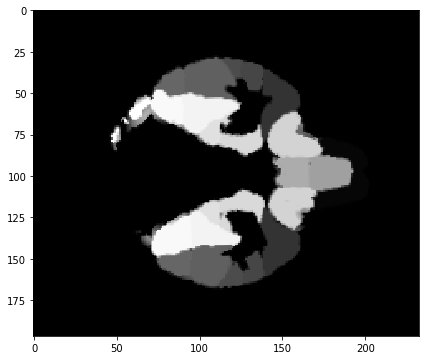

In [15]:
imgplot(harvard_mni, slice_no=[45])

In [16]:
#generating cortex mask from the atlas excluding all the regions of cerebrum 
harvard_mni_mask = ((harvard_mni.numpy()) > 0)*1

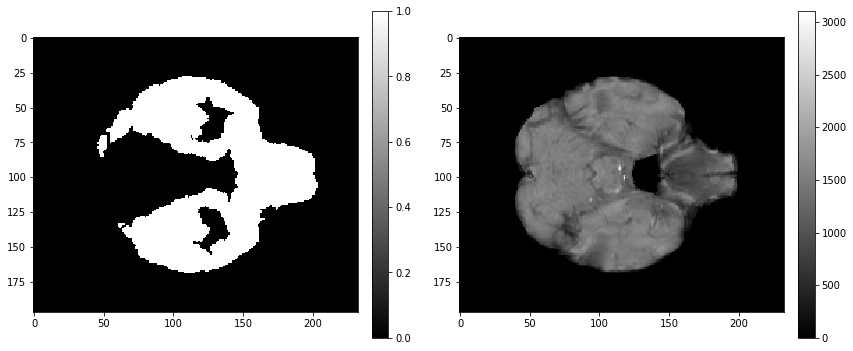

In [17]:
imgplot(harvard_mni_mask, im_patient, slice_no=[45,45])

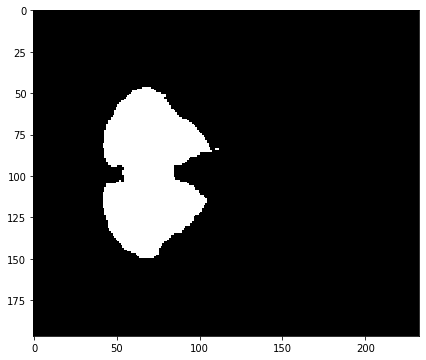

In [30]:
cerebellum_mni = cerebellum_mni.numpy()
cerebellum_mni = (cerebellum_mni == 2)
imgplot(cerebellum_mni, slice_no=[45])

In [16]:
cortex_regions = harvard_mni_mask * im_patient.numpy()

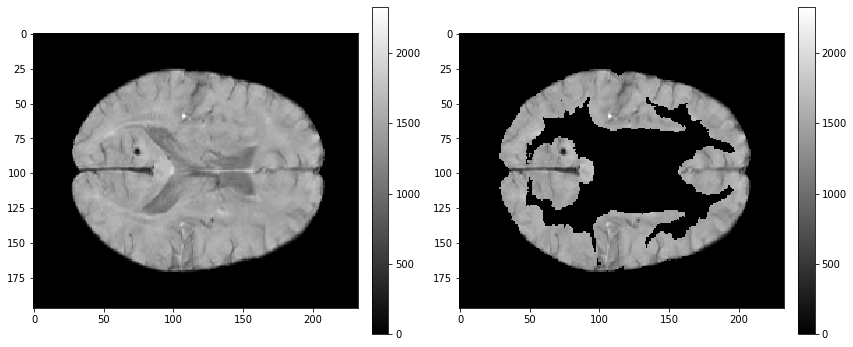

In [25]:
imgplot(im_patient, cortex_regions, slice_no=[85,85])

In [17]:
#Plot the cortex regions of the brain using the plot_brain function
plot_brain(cortex_regions)

In [17]:
#Calculating the rst output on the cortex image
rst_out = rst_3d(cortex_regions,2,2,0.2)

Time taken for 3D RST: 8.429842233657837


In [18]:
#calculating the RST output on the whole image
img_pat = im_patient.numpy()
rst_whole = rst_3d(img_pat, 2,2,0.2)

Time taken for 3D RST: 22.67804193496704


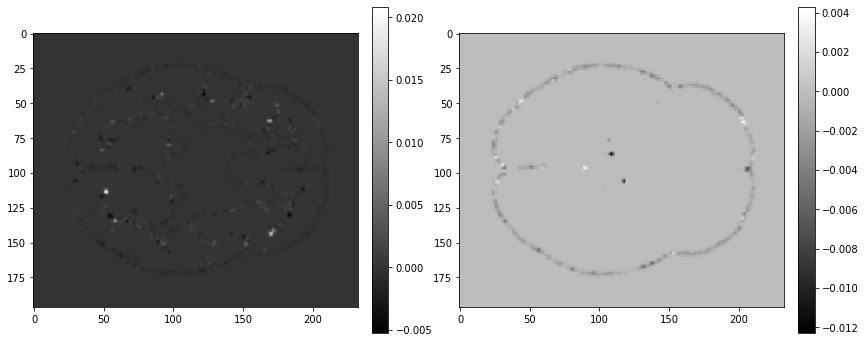

In [31]:
imgplot(rst_out,rst_whole,slice_no=[65,65])

In [32]:
#many false points are generated in the RST on the cortex image...so its better to apply mask on the rst_whole

In [19]:
rst_masked = rst_whole * harvard_mni_mask

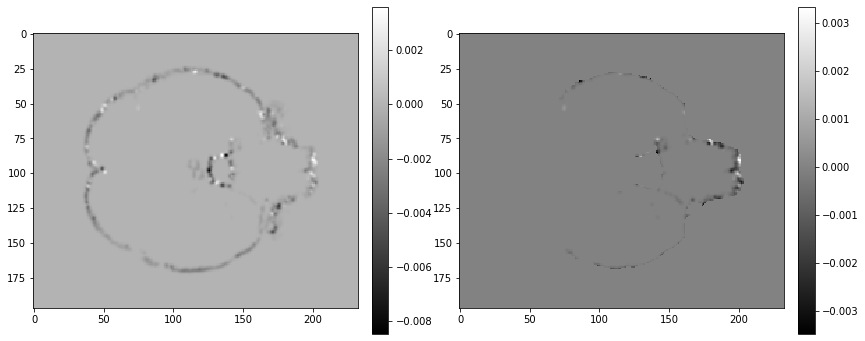

In [34]:
imgplot(rst_whole, rst_masked, slice_no=[45,45])

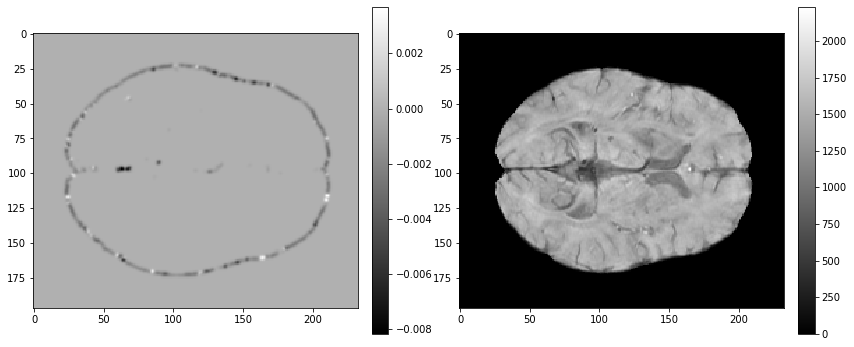

In [35]:
imgplot(rst_whole, img_pat, slice_no=[75,75])

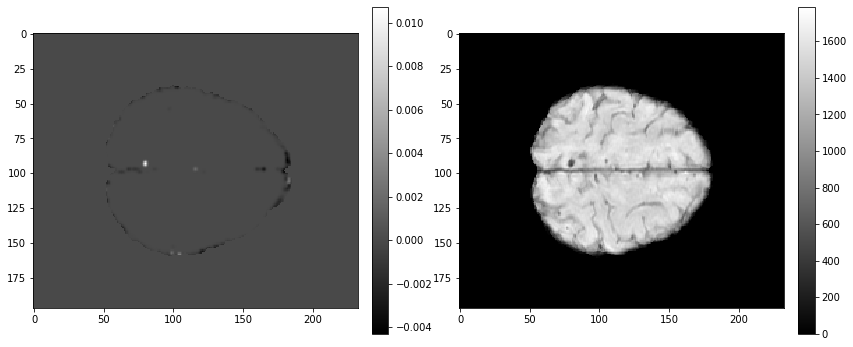

In [36]:
imgplot(rst_masked, img_pat, slice_no = [128,128])

In [20]:
#Extracting the candidate points from the RST output image
import skimage.feature as feature
from time import time
t1 = time()
peaks = feature.peak_local_max(rst_masked, min_distance=2,threshold_rel = 0.2)
t2 = time()
print("Time taken to find local maxima: " + str(t2-t1))

Time taken to find local maxima: 0.22772884368896484


In [21]:
peaks

array([[ 97,  91,  97],
       [ 93,  80, 128],
       [ 84,  74,  85],
       [ 53,  63,  96]])

In [22]:
#Next step is to cluster the regions with similar intensity levels....This can be a very simple
#clustering method where we can just cluster the regions around the microbleed with similar intensity levels
csf = ants.image_read(cur_path + '/datasets/mni_csf.nii')
mni_csf = mni_template_registration(cur_path, csf, 'mni_csf')

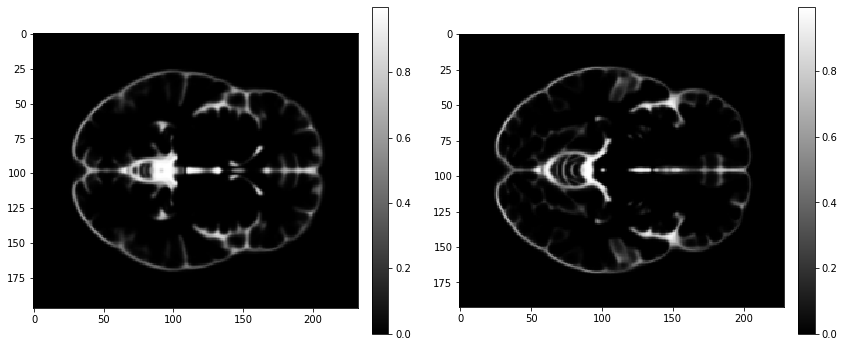

In [33]:
imgplot(mni_csf, csf, slice_no=[70,70])

In [23]:
#Developing binary mask for CSF and excluding the anatomical unnecessary points
from skimage.morphology import dilation, square, ball
cmap_prob = (mni_csf.numpy() > 0.1)*1
#csf_mask = 1 - cmap_prob
csf_dilated = dilation(cmap_prob, ball(1))

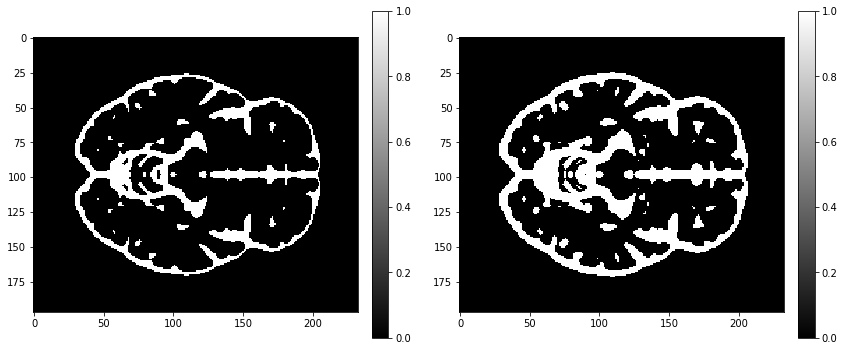

In [25]:
imgplot(cmap_prob, csf_dilated, slice_no=[60,60])

In [24]:
#applying binary mask to rst output
csf_mask = 1 - cmap_prob       #Inverted binary mask for rejecting csf points
rst_csf_masked = csf_mask * rst_masked

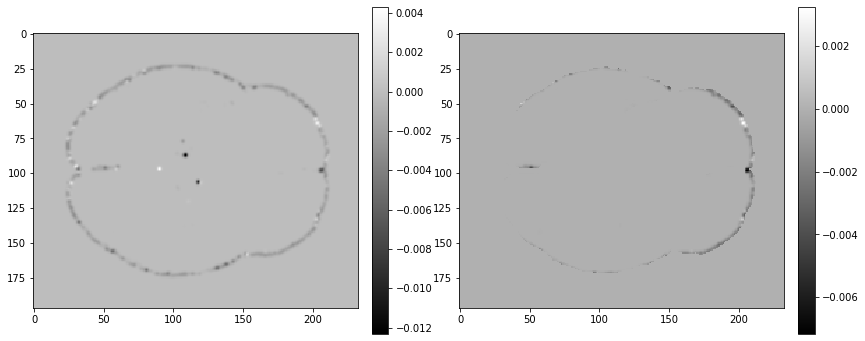

In [25]:
imgplot(rst_whole, rst_csf_masked, slice_no=[65,65])

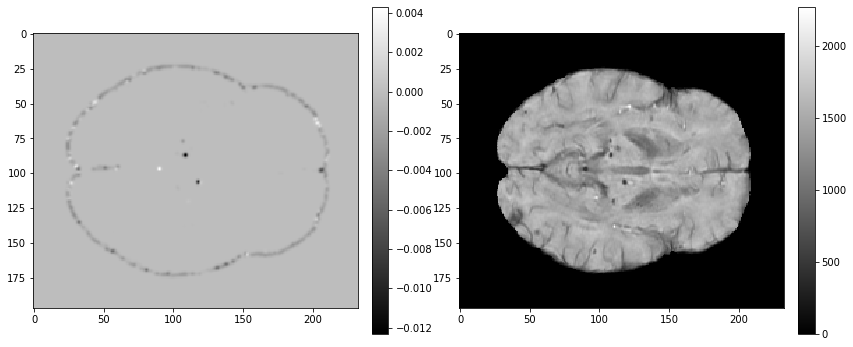

In [27]:
imgplot(rst_whole, img_pat, slice_no=[65,65])

In [25]:
#rejecting periphiral points to remove edge effect on RST output
brain_mask_whole = (img_pat > 0)*1
rst_per = rst_csf_masked * brain_mask_whole

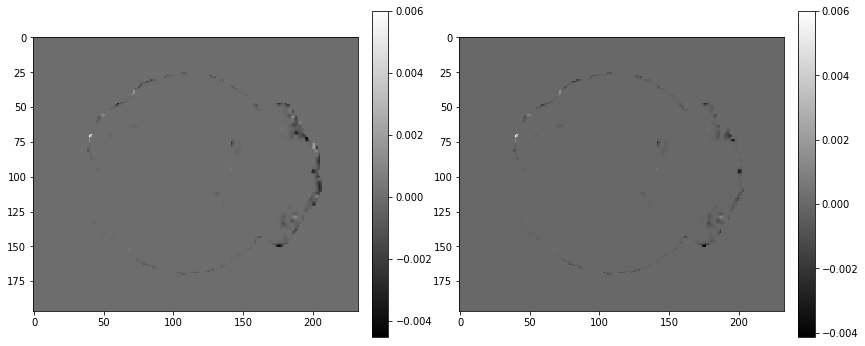

In [26]:
imgplot(rst_csf_masked, rst_per, slice_no=[50,50])

In [26]:
#Snipping out the cubical 3D region out of the candidate detection based on local peaks
def roi_snipping(image,peaks,r):
    import numpy as np
    roi_array = []  #list in which all the roi images will be stored
    for i in range(len(peaks)):
        p = peaks[i]
        temp = image[p[0]-r:p[0]+r, p[1]-r:p[1]+r, p[2]-r:p[2]+r]
        roi_array.append(temp)
    return roi_array    

In [27]:
snips = roi_snipping(img_pat,peaks,5)

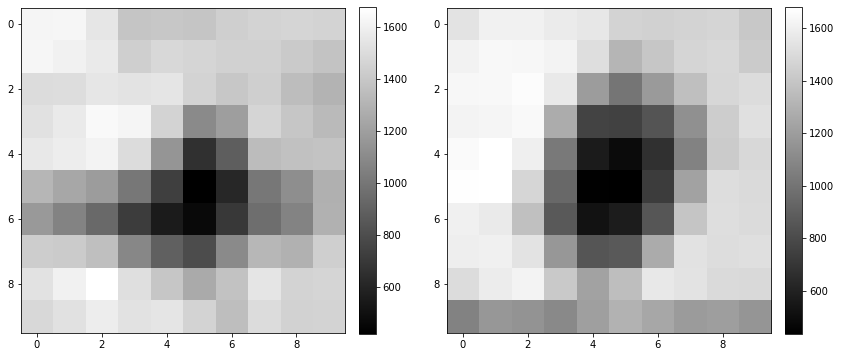

In [36]:
imgplot(snips[0], snips[1], slice_no=[4,4])

In [29]:
#draw ROI on the images and display the results
def draw_roi(image,peaks,r):
    ##Arguments:
    # image : 3D image on which the labelling is needed to be done
    # peaks : array containing the list of local maximas
    # r     : radius of the ROI bounding box
    import os
    import datetime
    from matplotlib import pyplot as plt
    from skimage.draw import rectangle_perimeter
    import matplotlib.patches as mpathches
    cur_path = os.getcwd()
    name = str((datetime.datetime.now()).strftime("%d%m%Y_%H%M%S")) + '.png'
    n = len(peaks)
    grid_n = int(n/2 if n%2 == 0 else ((n+1)/2))
    
    plt.figure(figsize = (12,14))
    for i in range(n):    
        p = peaks[i]
        temp = image[:,:,p[2]]
        plt.subplot(grid_n,2,i+1)
        plt.imshow(temp, cmap = plt.get_cmap('gray'))
        ax = plt.gca()
        rect = mpathches.Rectangle((p[1]-r, p[0]-r), 2*r, 2*r,
                                  fill= False, edgecolor = 'red', linewidth = 1)
        ax.add_patch(rect)
        #ax.set_axis_off()
    plt.tight_layout() 
    plt.savefig(cur_path + '/visuals/stills_2d/' + name)
    plt.show()

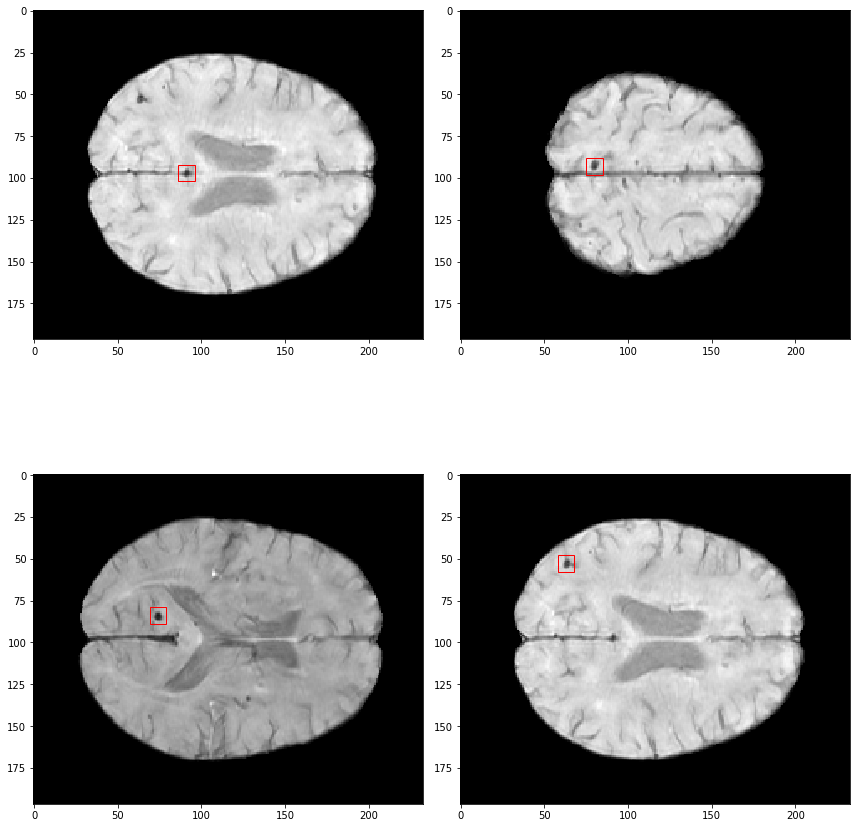

In [43]:
draw_roi(img_pat,peaks,5)

In [30]:
#snip a lot of non-microbleeds images from the subject image by traversing through it
#NOTE: Needs to be made more robest for module mode
def random_snips(image,r, n_snips):
    #Arguments -->
    #image   : 3D array for snipping. (Note: It must be MNI registered.)
    #r       : radius of the snipped image(in pixels)
    #n_snips : no of snips to be generated
    from random import randint
    import numpy as np
    import os
    cur_path = os.getcwd()
    indexes = []
    snips = []
    #import sys, os
    #sys.path.append(os.path.)
    from pfca.core.preprocessing import mni_template_registration
    harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')
    harvard_mask = (harvard_mni.numpy() > 0)*1
    indices = np.asarray(np.where(harvard_mask == 1)).T
    n_indices = len(indices)
    for i in range(n_snips):
        t = randint(0,n_indices)
        tmp_pt = indices[t]
        indexes.append(tmp_pt)
        tmp_snip = image[tmp_pt[0]-r:tmp_pt[0]+r, tmp_pt[1]-r:tmp_pt[1]+r, tmp_pt[2]-r:tmp_pt[2]+r]
        snips.append(tmp_snip)
    return snips, indexes    

In [31]:
rnd_snips, indices = random_snips(img_pat,5,6)

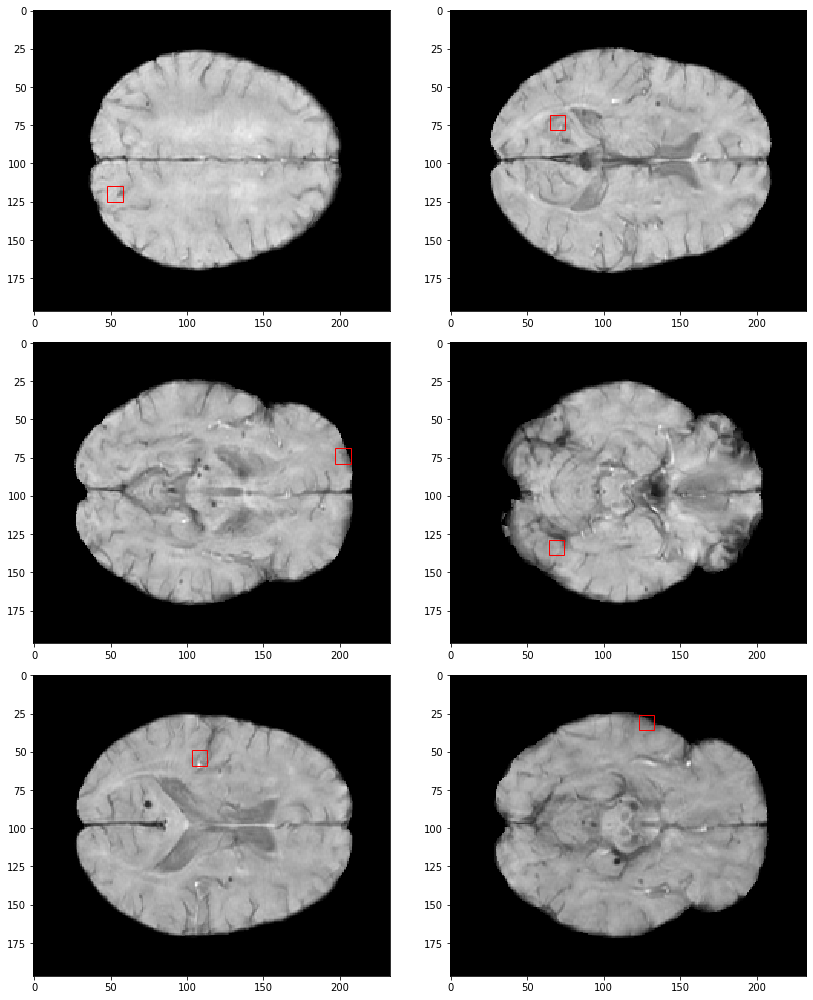

In [59]:
draw_roi(img_pat,indices,5)

In [32]:
#2D visualization using t-SNE, Isomap and PCA for estimating the effectiveness of feature space
#NOTE: Dimensions are reduced across columns
def viz_dimensional(feature_matrix, algo = 'tsne', colormap = None, labelmap = None, txtlabels = False):
    from matplotlib import pyplot as plt
    import datetime
    import os
    cur_path = os.getcwd()
    name = str((datetime.datetime.now()).strftime("%d%m%Y_%H%M%S")) + 'dimReduction.png'
    if algo == 'tsne':
        from sklearn.manifold import TSNE
        x_embed = TSNE(n_components=2).fit_transform(feature_matrix)
        plt_title = 't-Stochastic Neighbour Embedding(t-SNE) plot'
    elif algo == 'pca':
        from sklearn.decomposition import PCA
        pca = PCA(n_components = 2,svd_solver = 'full')
        pc_mat = PCA(n_components = 40,svd_solver = 'full').fit(feature_matrix)
        x_embed = pca.fit_transform(feature_matrix)
        plt_title = 'Principal Component Analysis(PCA) plot'
    elif algo == 'isomap':
        from sklearn.manifold import Isomap
        x_embed = Isomap(n_components=2).fit_transform(feature_matrix)
        plt_title = 'Isometric Mapping(Isomap) plot'
    elif algo == 'all':
        return
    else:
        print("Error: Some unknown value of algo argument is encountered. Aborting..")
    plt.figure(figsize= (12,8))
    ax =plt.gca()
    scale = np.ones(x_embed.shape[0]) * 100
    print(x_embed.shape)
    if (colormap == None) and (labelmap == None):
        ax.scatter(x_embed[:,0], x_embed[:,1], alpha = 0.3, s = scale)
    elif (colormap != None) and (labelmap != None):
        for ind in list(labelmap.keys()):
            index = ind.split(':')
            ax.scatter(x_embed[int(index[0]):int(index[1]),0], x_embed[int(index[0]):int(index[1]),1], 
                       alpha = 0.3, s = scale, c = colormap[int(index[0]):int(index[1])], label = labelmap[ind])
        ax.legend()
    else:
        print("Error: Either colorlist or label list is missing from the arguments.")
    
    
    if txtlabels == True:
        n = feature_matrix.shape[0]
        txts = list(np.arange(n)+1)
        for i, txt in enumerate(txts):
            ax.annotate(txt, (x_embed[i,0], x_embed[i,1]))
    
    ax.grid(True)
    plt.title(plt_title)
    plt.savefig(cur_path + '/visuals/stills_2d/' + name)
    #ax.set_axis_off()
    plt.show()    
    if algo == 'pca':
        return x_embed, pc_mat
    else:
        return x_embed

In [33]:
a = rnd_snips[0].reshape((50,20))

(50, 2)


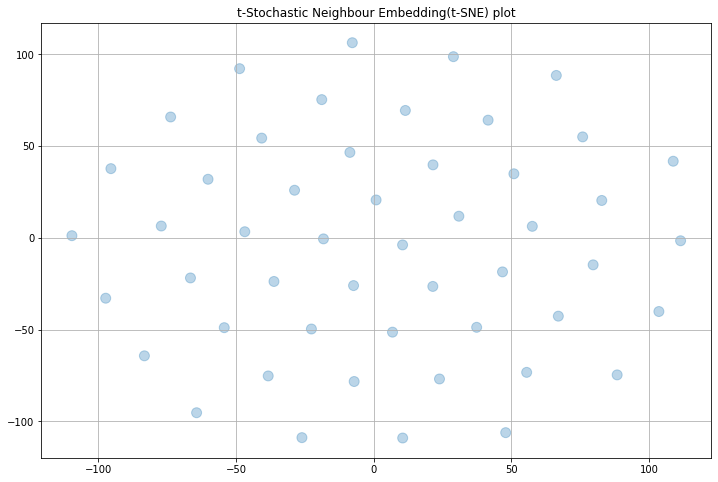

In [146]:
k1 = viz_dimensional(a, algo = 'tsne')

In [36]:
#generate colormap for the labels provided
def generate_colormap(array, label, color, c_matrix = None, l_matrix = None):
    #Arguments:
    #array  : just to get the size of the colormap
    #label  : the string label for all the datapoints in the array
    #color  : BGR value of the color where B,G,R are between 0 to 1(correspondingly 0 to 255)
    #matrix : matrix in which the colormap is needed to be appended
    n = array.shape[0]
    c = (color[0], color[1], color[2])
    if type(c_matrix).__name__ == 'NoneType' and type(l_matrix).__name__ == 'NoneType':
        l_matrix = {}
        l_matrix['0:'+str(n-1)] = label
        c_matrix = []
        for i in range(n):
            c_matrix.append(c)
        return c_matrix,l_matrix    
    elif type(c_matrix).__name__ != 'NoneType' and type(l_matrix).__name__ != 'NoneType':
        ind_list = list(l_matrix.keys())[-1]    #getting the last added label into l_matrix
        last_ind = int(ind_list.split(':')[-1]) #Converting the last index to an integer
        new_ind = last_ind + 1
        l_matrix[str(new_ind) + ':' + str(new_ind + n)] = label
        for i in range(n):
            c_matrix.append(c)
        return c_matrix, l_matrix    

In [37]:
#generate feature vector matrix for the visualization purpose
#NOTE: Works only for single snippet
def feature_matgen(data_pt,matrix = None):
    #Aruments:
    #data_pt : multidimensional data point which is to be added to matrix
    #matrix  : feature_matrix in which data_pt will be appended
    if type(matrix).__name__ == 'NoneType':
        feature_matrix = np.ravel(data_pt)
        feature_matrix = np.reshape(feature_matrix, (1,len(feature_matrix)))
        return feature_matrix
    else:
        temp = np.ravel(data_pt)
        if len(temp) != matrix.shape[1]:
            print("Error: The dimensions of matrix and unravelled data point doesn't match. Appending can't be done.")
        else:
            feature_matrix = np.vstack((matrix,temp))
            return feature_matrix

In [38]:
#converting the whole snippet list into a feature matrix
def snip_matrix(snip_list):
    #Arguments:
    #snip_list : list of snipped images 
    feature_matrix = feature_matgen(snip_list[0])
    for i in range(1, len(snip_list)):
        feature_matrix = feature_matgen(snip_list[i], feature_matrix)
    return feature_matrix    

In [39]:
feat = feature_matgen(rnd_snips[2]) #trying feature matrix generator function on a single snippet

In [40]:
feat = feature_matgen(rnd_snips[3],feat) #appending a new single snippet into the last feature matrix

In [41]:
rnd_snps, indices = random_snips(img_pat,5,100)   #generating random snippets from the 3D image
feat = snip_matrix(rnd_snps)                      #converting snippets into a feature matrix

In [126]:
#generating colormap for the visualization
#First, we generate the green color(0,1,0) for the random snippets
colormap,labels = generate_colormap(feat, 'random snips', color = [0,1,0])  

In [127]:
#converting the true detected Cerebral microbleed snippets into feature matrix
snips_mat = snip_matrix(snips)

In [128]:
#Appending the colormap and labelmap with the CMB points which will be in red color for visualization
clrmap, lbls = generate_colormap(snips_mat, 'Cerebral Microbleeds', color = [1,0,0]
                                 , c_matrix = colormap, l_matrix = labels)

In [129]:
#Checking for generated labels...This format of labels will work only in the viz_dimensional() function
lbls

{'0:99': 'random snips', '100:104': 'Cerebral Microbleeds'}

(100, 2)


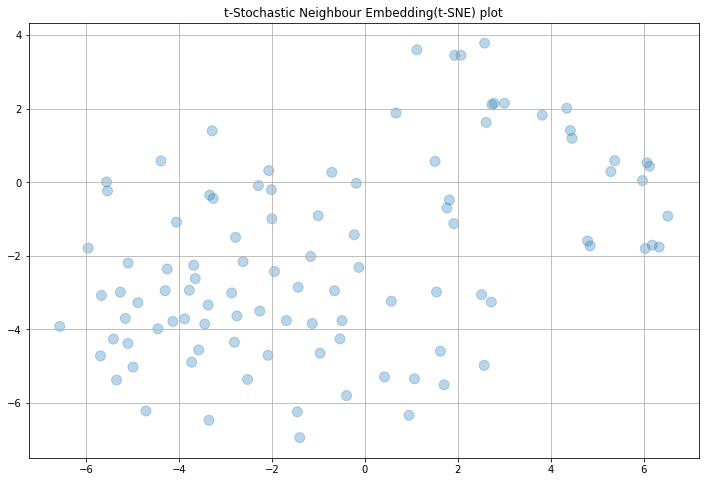

In [46]:
#visualizing only random snippets
viz_dimensional(feat, algo = 'tsne')

In [47]:
#generating the complete feature matrix consisting of all the data points (random snips + CMBs)
cmb_matrix = snip_matrix(snips)
feat_full = np.vstack((feat,cmb_matrix))

(104, 2)


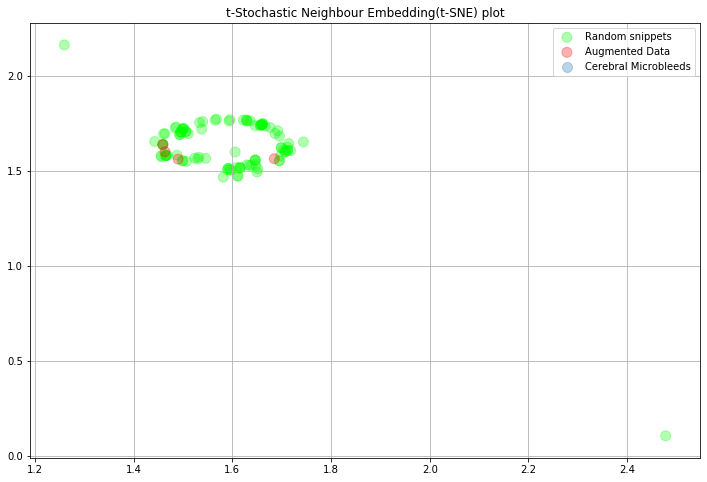

In [149]:
#Visualization of random snippets along with cerebral microbleed snippets
reduced_space = viz_dimensional(feat_full,algo = 'tsne', colormap = clrmap, labelmap = lbls)

(104, 2)


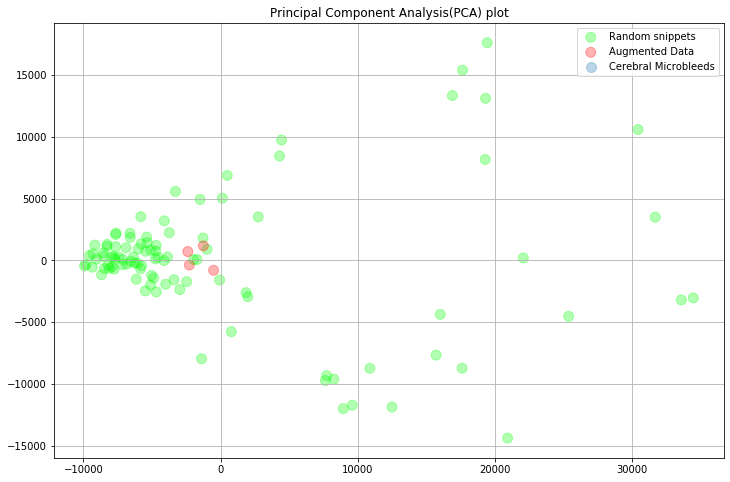

In [147]:
#draw_roi(img_pat, indices[0:6], 5)
fg = viz_dimensional(feat_full,algo = 'pca', colormap = clrmap, labelmap = lbls)

In [50]:
#T2 CSF exclusion from MRI
#First we will use MNI 152 template to remove CSF from RST


In [37]:
#dataset generation for the semi-supervised classification task
#Here, generating non-targets for the classification
non_targets, indices = random_snips(img_pat,5,1000)

In [136]:
images_arr = np.array(non_targets)
ind = np.array(indices)

In [42]:
def store_dataset(images, labels, name):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    import h5py
    import os
    cur_path = os.getcwd()
    num_images = len(images)
    
    hdf5_dir = cur_path + '/datasets/learning/'
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir + f"{num_images}_" + name + ".h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U16BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U16BE, data=labels
    )
    file.close()
    print("Dataset " + name + " stored Successfully!")

In [55]:
store_dataset(images_arr, ind, 'non_targets')

Dataset non_targets stored Successfully!


In [43]:
def read_hdf_dataset(name):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    import os
    import h5py
    cur_path = os.getcwd()
    images, labels = [], []
    hdf5_dir = cur_path + '/datasets/learning/'
    # Open the HDF5 file
    file = h5py.File(hdf5_dir + f"{name}" + ".h5", "r+")
    return file

In [61]:
non_target_data = read_hdf_dataset('1000_non_targets')

In [44]:
#creating a filler image for the border pixels so that there are no edges with zero elements
def border_filler(image, border_width):
    x,y,z = image.shape
    tmp_im = image.copy()
    tmp_im[1:(x-border_width), 1:(y-border_width), 1:(z-border_width)] = 0
    return tmp_im

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


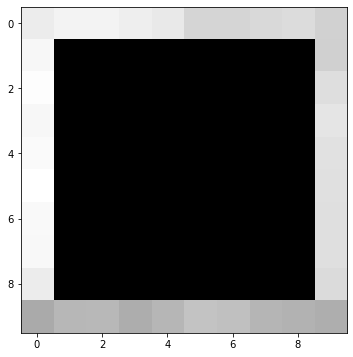

In [63]:
border = border_filler(snips[1], 1)
imgplot(border)

In [45]:
#Rotation and shape deformation for the augmentation task
def im_rotate(image, angle, axes):
    #Arguments:
    #image - 3D or 2D image to be rotated
    #angle - should be in Degrees
    border_width = 1
    from scipy import ndimage
    x,y,z = image.shape
    img_rot = ndimage.rotate(image, angle, reshape = False, axes = axes)
    tmp = img_rot.copy()
    tmp[1:(x-border_width), 1:(y-border_width), 1:(z-border_width)] = 0
    without_border = img_rot - tmp
    border = border_filler(image,1)
    img_adj = without_border + border
    return img_adj

In [47]:
#performing data augmentation for the targets in order to increase their quantity since their number are limited
aug_data = []
for i in range(0,270,10):
    tmp_img = im_rotate(snips[3],i,axes = (1,0))
    aug_data.append(tmp_img)

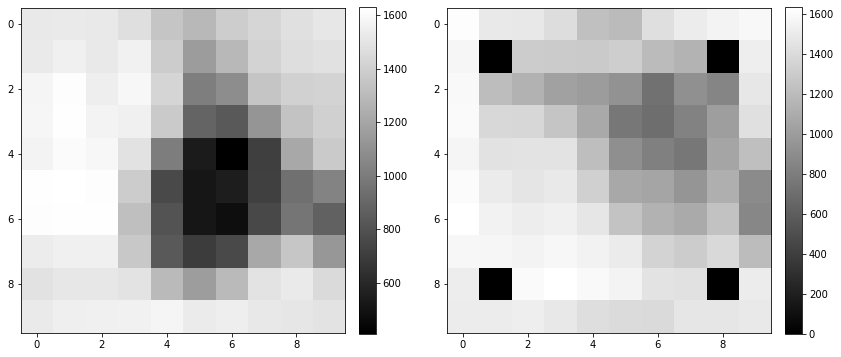

In [137]:
imgplot(snips[3], aug_data[5], slice_no=[5,8])

In [138]:
feat1 = snip_matrix(rnd_snps)
feat2 = snip_matrix(aug_data)
mains = snip_matrix(snips)

In [139]:
colors, labels = generate_colormap(feat1, 'Random snippets', [0,1,0])
cl2, lbl2 = generate_colormap(feat2, 'Augmented Data', [0,0,1], c_matrix=colors, l_matrix=labels)
clrs, lbls = generate_colormap(mains, 'Cerebral Microbleeds', [1,0,0], c_matrix=cl2, l_matrix=lbl2)

In [140]:
lbls

{'0:99': 'Random snippets',
 '100:127': 'Augmented Data',
 '128:132': 'Cerebral Microbleeds'}

In [141]:
feat_mat1 = np.vstack((feat1, feat2))
feat_mat = np.vstack((feat_mat1, mains))

(131, 2)


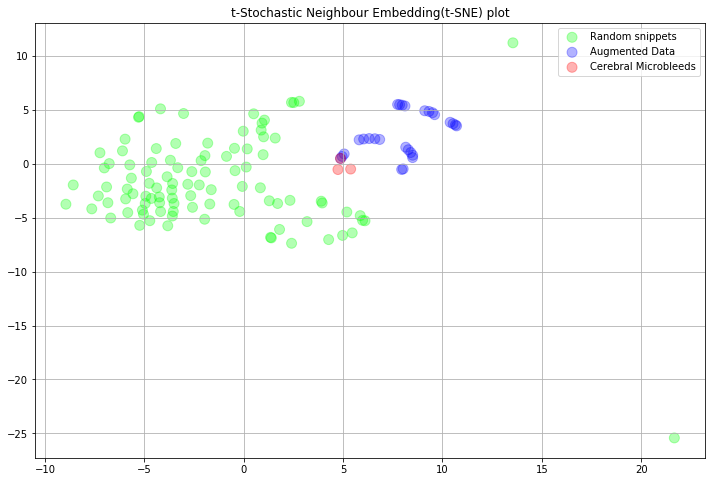

In [142]:
red_spc = viz_dimensional(feat_mat, algo = 'tsne', colormap = clrs, labelmap = lbls)

(131, 2)


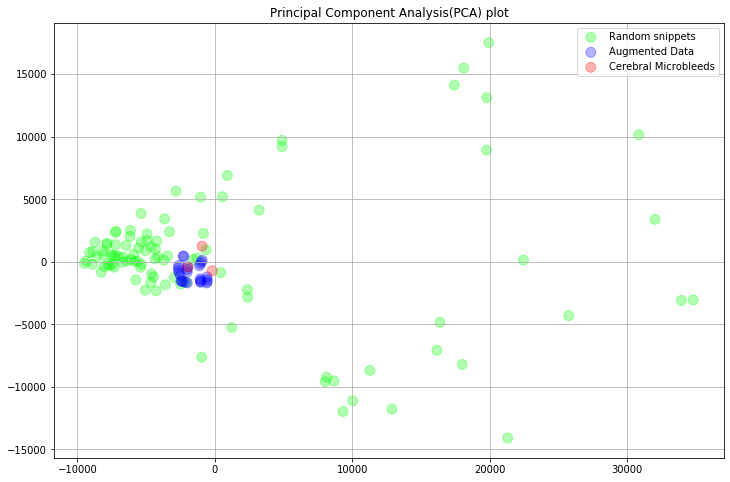

In [72]:
viz_dimensional(feat_mat, algo = 'pca', colormap = clrs, labelmap = lbls)

(131, 2)


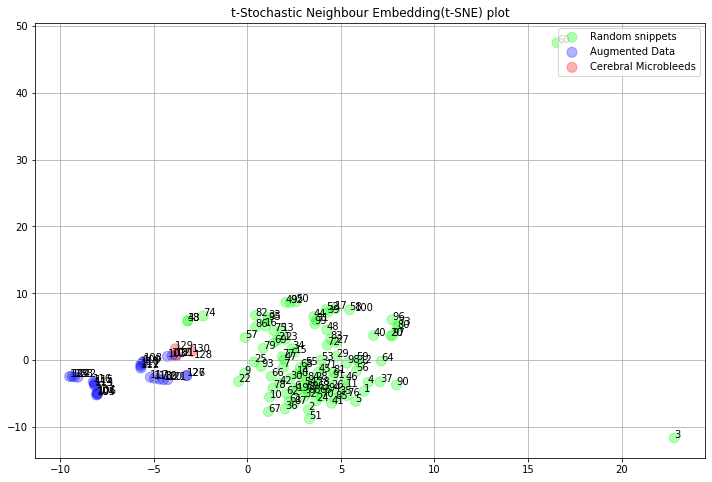

In [152]:
a = viz_dimensional(feat_mat, algo = 'tsne', colormap = clrs, labelmap = lbls, txtlabels = True)

In [86]:
image = feat_mat[108].reshape((10,10,10))

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


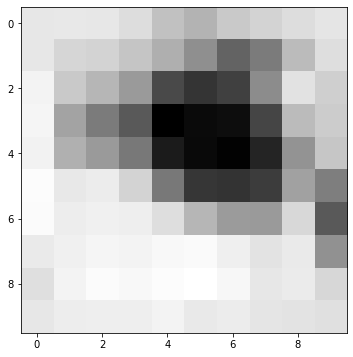

In [87]:
imgplot(image)

In [89]:
from sklearn.cluster import KMeans

In [186]:
km = KMeans(n_clusters=2, init='random', n_init = 50, max_iter = 3000,tol=1e-03,random_state = 0)

In [153]:
y_km = km.fit_predict(a)

In [154]:
y_km

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [113]:
import umap

In [118]:
embeddings = umap.UMAP().fit_transform(feat_full)

<function matplotlib.pyplot.show(*args, **kw)>

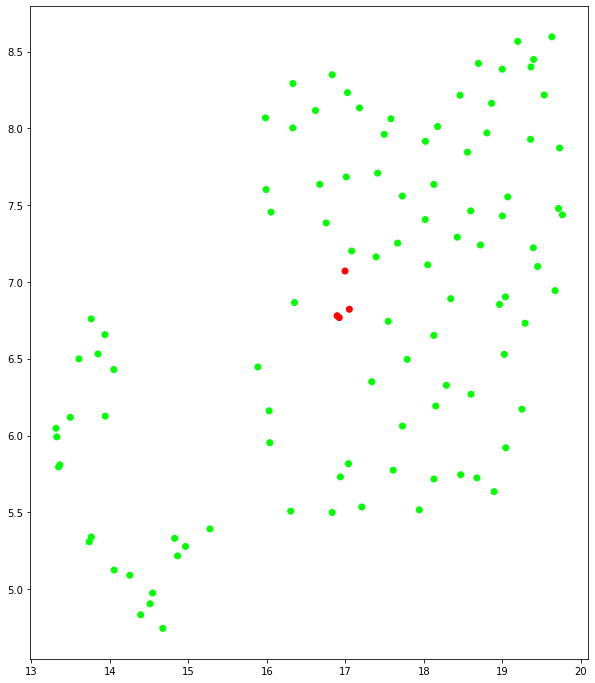

In [132]:
plt.figure(figsize = (10,12))
plt.scatter(embeddings[:,0], embeddings[:,1], c = clrmap)
plt.show

In [131]:
len(clrmap)

104

In [155]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [156]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(a)

In [162]:
dbscan = DBSCAN(eps = 0.250, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

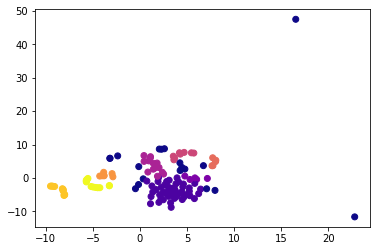

In [163]:
plt.scatter(a[:,0], a[:,1], c = clusters, cmap = "plasma")
plt.show()

In [167]:
feat_mat.shape

(131, 1000)

In [171]:
from sklearn.decomposition import PCA

In [178]:
pca = PCA(n_components=120, svd_solver='full')

In [179]:
red = pca.fit_transform(feat_mat)

In [180]:
red.shape

(131, 120)

(131, 2)


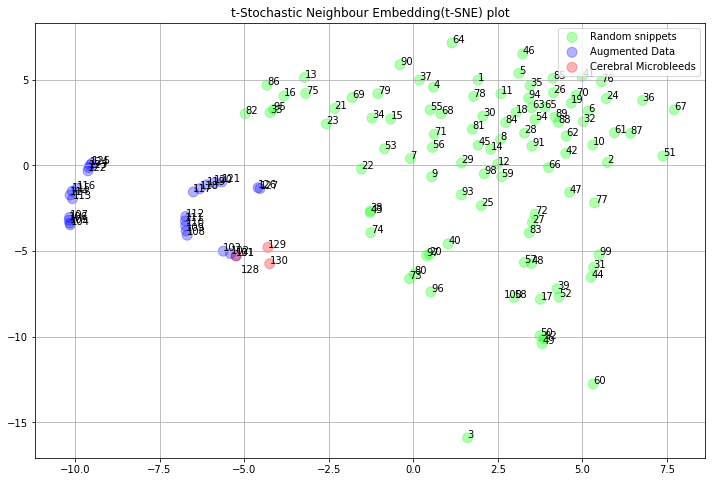

In [181]:
kml = viz_dimensional(red, algo = 'tsne', colormap = clrs, labelmap = lbls, txtlabels = True)

In [187]:
y_kmeans = km.fit_predict(kml)

In [188]:
y_kmeans

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

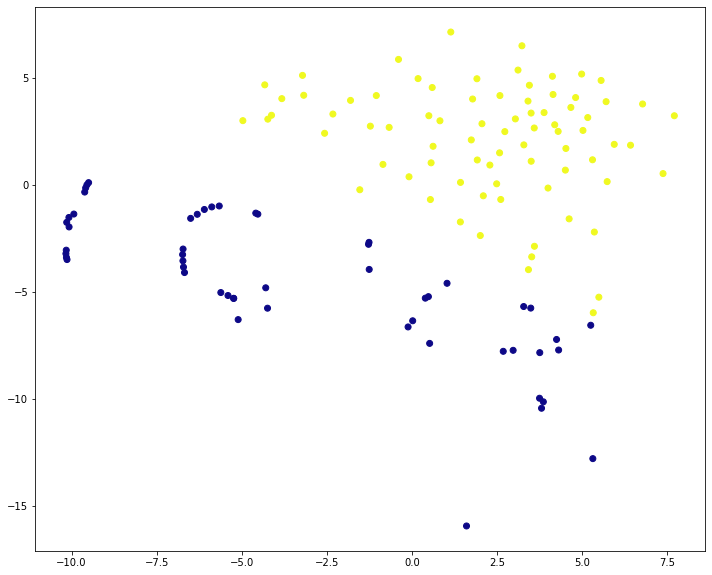

In [191]:
plt.figure(figsize = (12,10))
plt.scatter(kml[:,0], kml[:,1], c = y_kmeans, cmap = "plasma")
plt.show()

In [43]:
#feature extraction using HOG and other measures
from skimage.feature import hog

In [41]:
feature1 = hog(snips[0], pixels_per_cell = (2,2), visualize = True)

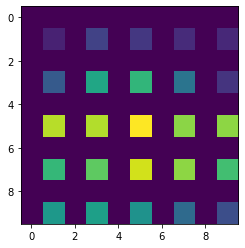

In [42]:
#function to convert all the images into feature vectors using the hog method
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(feature1[1])

In [75]:
non_targets, indices = random_snips(img_pat,5,100)

In [76]:
features = []
for i in range(len(snips)):
    feature_vector = hog(snips[i], pixels_per_cell = (2,2))
    features.append(feature_vector)

In [77]:
len(features)

4

In [78]:
mat1 = snip_matrix(features)

In [79]:
clr, label = generate_colormap(mat1, 'CMBs', color = [0,1,0])  

In [80]:
#non_targets
for i in range(len(non_targets)):
    feature_vector = hog(non_targets[i], pixels_per_cell = (2,2))
    features.append(feature_vector)

In [81]:
len(features)

104

In [82]:
mat2 = snip_matrix(features[4:])

In [83]:
#Appending the colormap and labelmap with the CMB points which will be in red color for visualization
clrmap, lbls = generate_colormap(mat2, 'Random Snippets', color = [1,0,0]
                                 , c_matrix = clr, l_matrix = label)

In [84]:
feature_matrix = np.vstack((mat1,mat2))

In [85]:
feature_matrix.shape

(104, 729)

(104, 2)


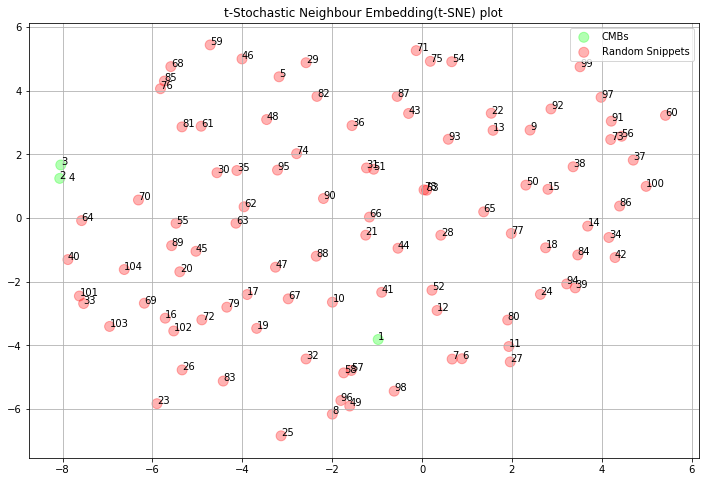

In [89]:
feature_viz_tsne = viz_dimensional(feature_matrix, algo = 'tsne', colormap = clrmap, labelmap = lbls, txtlabels = True)

(104, 2)


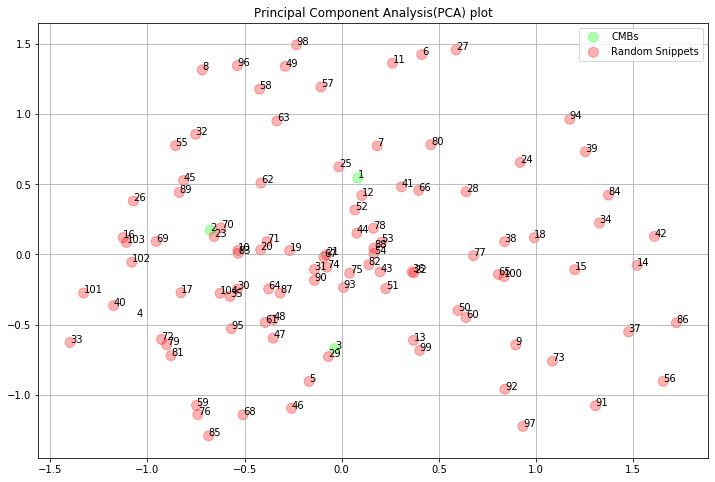

In [90]:
feature_viz_pca = viz_dimensional(feature_matrix, algo = 'pca', colormap = clrmap, labelmap = lbls, txtlabels = True)

<h1>The stuff about feature extraction and selection starts here...</h1>
<h3>The new kind of augmentation along with the Visual Bag of Words(BOW) implementation</h3>
</br>

In [48]:
#Trying the augmentation again using an enlarged ROI in order to perform the rotations correctly
#img_pat : 3d image of the patient MRI
#peaks   : center points of the CMBs
target_snips_big = roi_snipping(img_pat,peaks,10)

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


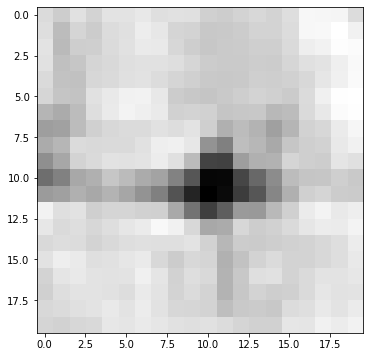

In [42]:
imgplot(target_snips_big[0])

In [49]:
#performing the rotation augmentation for the bigger image
aug_data_new = []
for j in range(1,4,1):
    for i in range(0,270,5):
        tmp_img = im_rotate(target_snips_big[j],i,axes = (1,0))
        aug_data_new.append(tmp_img)

In [50]:
len(aug_data_new)

162

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


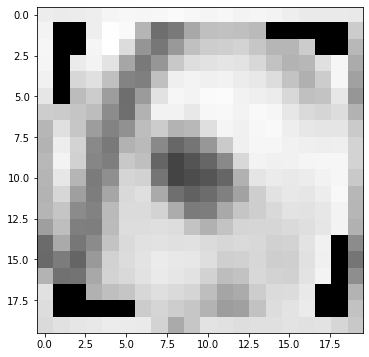

In [45]:
imgplot(aug_data_new[50])

In [51]:
#center cropping
#cropping the image in a specified range from the center
#Done in order to eliminate the edge effect on the rotated image(as shown above)
#works only on the 3D image
def center_crop(image, r):
    center = [int(image.shape[0]/2), int(image.shape[1]/2), int(image.shape[2]/2)]
    crop = image[(center[0] - r):(center[0] + r), (center[1] - r):(center[1] + r), (center[2] - r):(center[2] + r)]
    return crop

In [52]:
#Cropping all the augmented images in order to get the (10*10*10) images
target_snips = []
for i in range(len(aug_data_new)):
    im_temp = center_crop(aug_data_new[i], 5)
    target_snips.append(im_temp)

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


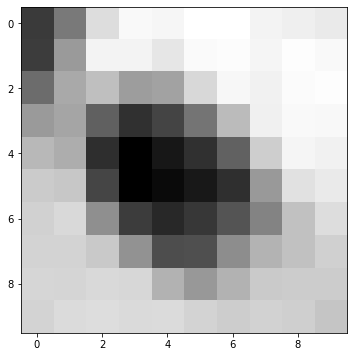

In [48]:
imgplot(target_snips[50])

In [53]:
non_target_patches, indices_rand = random_snips(img_pat,5,162)

In [54]:
feat1 = snip_matrix(non_target_patches)
feat2 = snip_matrix(target_snips)
mains = snip_matrix(snips)

In [55]:
colors, labels = generate_colormap(feat1, 'Random snippets', [0,1,0])
cl2, lbl2 = generate_colormap(feat2, 'Augmented Data', [0,0,1], c_matrix=colors, l_matrix=labels)
clrs, lbls = generate_colormap(mains, 'Cerebral Microbleeds', [1,0,0], c_matrix=cl2, l_matrix=lbl2)

In [56]:
lbls

{'0:161': 'Random snippets',
 '162:324': 'Augmented Data',
 '325:329': 'Cerebral Microbleeds'}

In [57]:
feat_mat1 = np.vstack((feat1, feat2))
feat_mat = np.vstack((feat_mat1, mains))

(328, 2)


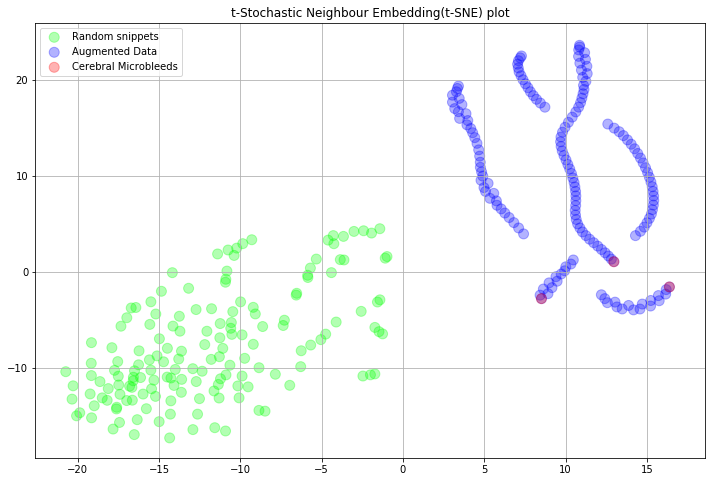

In [131]:
red_spc = viz_dimensional(feat_mat, algo = 'tsne', colormap = clrs, labelmap = lbls)

(328, 2)


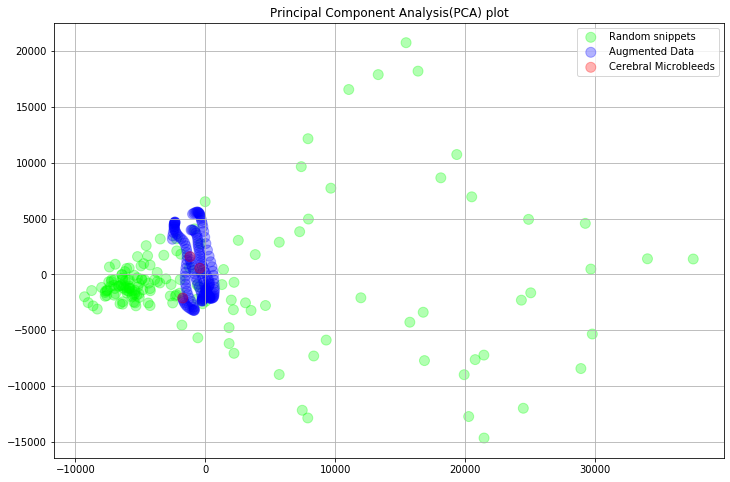

In [54]:
red_spc, pc_mat = viz_dimensional(feat_mat, algo = 'pca', colormap = clrs, labelmap = lbls)

Text(0, 0.5, 'Cumulative Explained Variance')

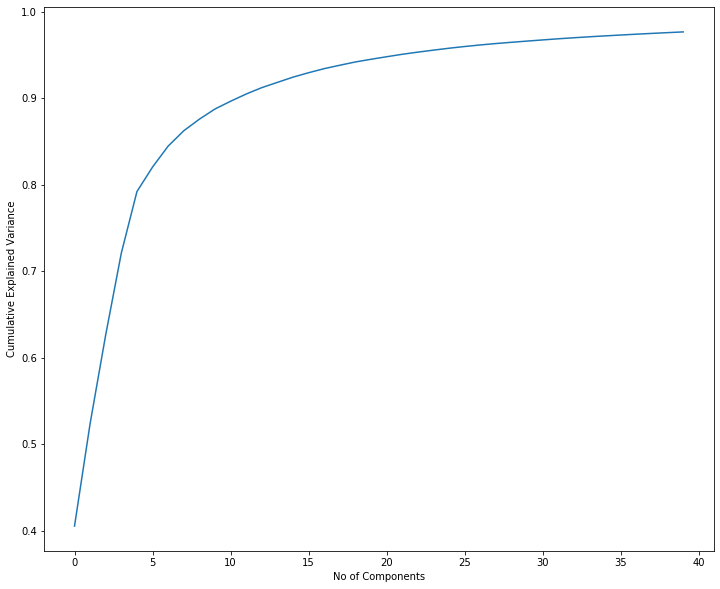

In [55]:
#Calculating the cumulative explained variance ratio(Energy of the components) in order to look for the appropriate no of components
plt.figure(figsize = (12,10))
plt.plot(np.cumsum(pc_mat.explained_variance_ratio_))
plt.xlabel('No of Components')
plt.ylabel('Cumulative Explained Variance')

In [144]:
non_targets_162 = np.array(non_target_patches)
augmented_162 = np.array(target_snips)
target_162 = np.array(snips)
keypoint_non_targets_162 = np.array(indices_rand)
keypoint_target_162 = np.array(peaks)

In [146]:
#store this dataset
store_dataset(non_targets_162, keypoint_non_targets_162, 'Non_targets_162')
store_dataset(augmented_162, keypoint_target_162, 'Augmented_162')
store_dataset(target_162, keypoint_target_162, 'Target_162')

Dataset Non_targets_162 stored Successfully!
Dataset Augmented_162 stored Successfully!
Dataset Target_162 stored Successfully!


In [133]:
#Developing Visual Bag of words using dense sampling of raw patches of interest points

In [147]:
#Normalization of the image patches
normalized_targets = []
for i in range(len(snips)):
    mean = np.mean(snips[i])
    std = np.std(snips[i])
    normalized = (snips[i] - mean)/std
    normalized_targets.append(normalized)

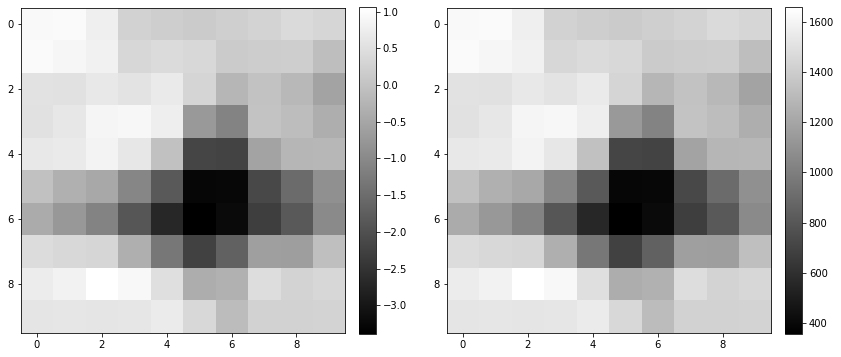

In [151]:
imgplot(normalized_targets[0], snips[0], slice_no= [5,5])

In [152]:
#whitening of the raw patches of target
#Using whiten function in scipy
from scipy.cluster.vq import whiten

In [153]:
whitened_targets = []
for i in range(len(normalized_targets)):
    white = whiten(normalized_targets[i])
    whitened_targets.append(white)

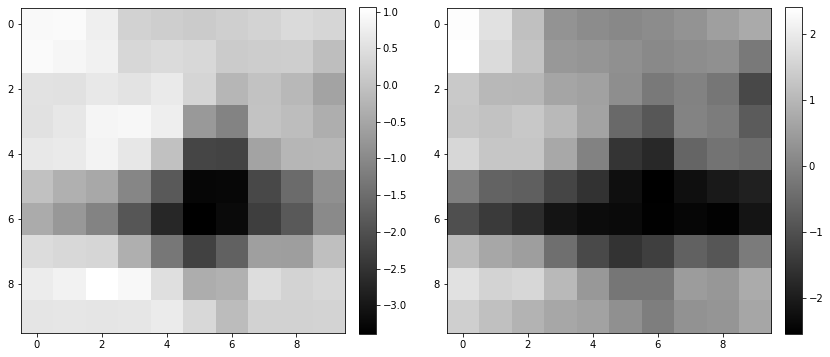

In [154]:
imgplot(normalized_targets[0], whitened_targets[0], slice_no=[5,5])

In [156]:
#developing the matrix of all features
targets = snip_matrix(whitened_targets)

In [84]:
#Trying out the same procedure on the small patches of each 3D image patches
#taking a (2*2*2) patches in each image with a stride of 2
#So, in a (10*10*10) image, it gives 125 patches or keypoints.

#Generating the 125 patches from each image
#Function works for 3d images and generate 3d patches
def img_keypoints(image, size, stride):
    patches = []
    for i in range(0,image.shape[0],stride):
        for j in range(0,image.shape[1],stride):
            for k in range(0,image.shape[2],stride):
                temp = image[i:i+size, j:j+size, k:k+size]
                #print(temp)
                patches.append(temp)
    return patches            

#This function is for collecting the keypoint descriptors from the whole batch
def img_batch_keypoints(batch, size, stride):
    patches = []
    for image in batch:
        for i in range(0,image.shape[0],stride):
            for j in range(0,image.shape[1],stride):
                for k in range(0,image.shape[2],stride):
                    temp = image[i:i+size, j:j+size, k:k+size]
                    #print(temp)
                    patches.append(temp)
    return patches            

<h3>Dataset class declaration for dataset handling and splitting using Pandas<h3>

In [242]:
#dictionary generation for data handling
#This dictionary will be easily managable using this function since it will be able to append more data
#into the same dictionary
class data_dictionary:
    def __init__(self):
        import pandas as pd
        import numpy as np
        self.dataset = pd.DataFrame(columns = ['image','label','session'])
        self.splitted = False
        #self.labels = None
        
    def append(self, data, labelling, session = np.nan, resplit = False):
        #add the images into the dictionary along with the label
        #dataset : list of image patches
        #label : target/non-target as 0/1
        for i in range(len(data)):
            if labelling == 'target':
                temp = {'image':[data[i]], 'label':1, 'session':session}
                #print(labelling)
            elif labelling == 'non_target':
                temp = {'image':[data[i]], 'label':0, 'session':session}
                #print(labelling)
            else:
                temp = {'image':[data[i]], 'label': labelling, 'session':session}
            #append the temporary dataframe into the dataset frame
            tempo = pd.DataFrame.from_records(temp)
            self.dataset = self.dataset.append(tempo, ignore_index = True, sort = True)
        #Finally, if some data is appended, it can be splitted again
        if resplit == True:
            self.splitted = False
            print("Respilit allowed. To split the data again, use the train_test_split() now!")
            
    def disp_by_index(self, index):
        #display a specific image according to the index value of the dataset matrix
        return (self.dataset.iloc[index])['image']
    
    def return_by_label(self,label):
        #Return a list of images based on the label(target/non-target)
        k = self.dataset
        if label == 'target':
            return k.loc[k['label'] == 1]
        elif label == 'non_target':
            return k.loc[k['label'] == 0] 
        
    def train_test_split(self, ratio = 0.7, balanced = True):
        #Arguments:
        #data_dictionary - dictionary datatype which contains labels for the images(0 - non target, 1 - target)
        #ratio - train_dataset_size / total_dataset_size
        #
        #give session labels to the data points : 'train', 'test', 'validation'
        k = self.dataset
        targets = k.loc[k['label'] == 1]
        non_targets = k.loc[k['label'] == 0]
        
        n_targets = len(targets)
        n_non_t = len(non_targets)
        
        n_comm = min(n_targets, n_non_t)
        list_target = targets.index.values
        list_non_targets = non_targets.index.values
        
        if self.splitted == True:
            print("Dataset splitting already happened! Aborting..")
        elif balanced == True and self.splitted == False:   #It will produce a balanced class with equal no of targets and non-targets
            #Decategorizing data in case of appending
            k['session'] = np.nan
            
            num = int(ratio * n_comm) #no of target points to select
            
            trainees = np.random.choice(list_target, size = (num,), replace = False)
            trainees2 = np.random.choice(list_non_targets, size = (num,), replace = False)
            all_train = np.append(trainees,trainees2)
            k.loc[all_train, ['session']] = 'train' #Labelling the datapoints as training points

            num_test = n_comm - num  #No of test target points
            target_left = k.loc[(k['label'] == 1) & (k['session'] != 'train')]
            non_targets_left = k.loc[(k['label'] == 0) & (k['session'] != 'train')]
            list_target_left = target_left.index.values
            list_non_targets_left = non_targets_left.index.values
            tests1 = np.random.choice(list_target_left, size = (num_test,), replace = False)
            tests2 = np.random.choice(list_non_targets_left, size = (num_test,), replace = False)
            all_test = np.append(tests1,tests2)
            k.loc[all_test, ['session']] = 'test' #Labelling the datapoints as training points
            self.splitted = True
            self.dataset = k
            return
        
    def feature_matrix_raw(self, session, ravel = True):
        if self.splitted == False:
            print("Dataset not ready for classification step. Please perform train-test split first.")
        elif self.splitted == True:
            k = self.dataset
            all_session_data = k.loc[k['session'] == session]
            
            img_dim = (all_session_data.iloc[0]['image']).shape
            feature_vector_len = img_dim[0]*img_dim[1]*img_dim[2]
            
            features = []
            labels = []
            
            for idx in range(len(all_session_data)):
                #print(idx)
                t_img = np.array((all_session_data.iloc[idx])['image'])
                labels.append(all_session_data.iloc[idx]['label'])
                features.append(t_img)

            labels = np.array(labels)    
            
            if ravel == True:
                feature_matrix = np.zeros((len(all_session_data), feature_vector_len))
                for i in range(len(all_session_data)):
                    feature_matrix[i,:] = np.ravel(features[i])
                return feature_matrix, labels
            elif ravel == False:
                return features, labels

    def show(self):
        return self.dataset

In [307]:
del dataset
np.nan

nan

In [308]:
dataset = data_dictionary()
dataset.append(non_target_patches, 'non_target')
dataset.append(target_snips, 'target')

In [309]:
print(len(dataset.show()))
dataset.train_test_split(0.7)

324


In [72]:
len((dataset.show()).loc[((dataset.show())['session'] == 'train') & ((dataset.show())['label'] == 0)])

113

In [228]:
len((data_dict.show()).loc[(data_dict.show())['session'] == 'test'])

98

In [229]:
data_dict.append(snips, 'target', resplit = True)

Respilit allowed. To split the data again, use the train_test_split() now!


In [230]:
data_dict.append(snips, 'target', resplit = True)

Respilit allowed. To split the data again, use the train_test_split() now!


In [231]:
data_dict.train_test_split(0.7)

In [232]:
data_dict.train_test_split(0.7)

Dataset splitting already happened! Aborting..


In [233]:
len((data_dict.show()).loc[((data_dict.show())['session'] == 'train') & ((data_dict.show())['label'] == 1)])

113

In [234]:
#leftovers...not sessioned due to balanced class condition
f = (data_dict.show())
(f.loc[(f['label'] == 1) & (f['session'] != 'test') & (f['session'] != 'train')])

,image,label,session
175,"[[[1600.8624, 1557.6809, 1508.812, 1465.9185, ...",1,NaN
185,"[[[1560.5886, 1546.8628, 1528.784, 1507.2478, ...",1,NaN
190,"[[[1590.3398, 1582.3976, 1570.2817, 1551.9672,...",1,NaN
229,"[[[1364.6898, 1440.5293, 1517.5603, 1569.7489,...",1,NaN
236,"[[[1549.6674, 1613.3604, 1719.0594, 1730.8169,...",1,NaN
251,"[[[1236.291, 1394.1003, 1521.0898, 1596.3297, ...",1,NaN
258,"[[[1431.9308, 1464.0942, 1520.8519, 1562.7938,...",1,NaN
277,"[[[1519.439, 1478.7294, 1459.8978, 1452.0642, ...",1,NaN


In [235]:
k = (f.loc[(f['session'] == 'train')])

Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


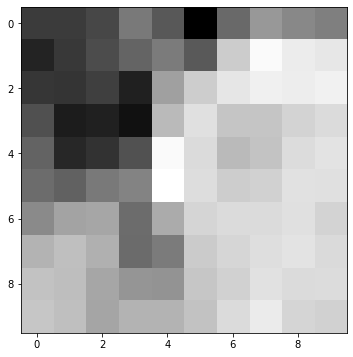

In [146]:
(np.array(data_dict.show().iloc[0]['image'])).shape
imgplot((np.array(data_dict.show().iloc[0]['image'])))

In [170]:
#Taking out feature matrix if we want to perform some classification
x,y = dataset.feature_matrix(session = 'train')

In [171]:
y #balanced class with equal no of targets and non-targets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

<h2>Visual Bag of words implementation using the above defined class</h2>
<h3>Whitening, feature descriptors and histogram implementation</h3>

In [256]:
#Normalization of the image patches
#normalized_features = []
#Useless Functions......
def normalize(snips):
    if snips is list:
        normalized_features = []
        for i in range(len(snips)):
            mean = np.mean(snips[i])
            std = np.std(snips[i])
            normalized = (snips[i] - mean)/std
            normalized_features.append(normalized)
        return normalized_features  
    if snips is not list:
        mean = np.mean(snips)
        std = np.std(snips)
        normalized = (snips - mean)/std
        return normalized

def whitening(normalized_targets):
    from scipy.cluster.vq import whiten
    import numpy as np
    if normalized_targets is list:
        whitened_targets = []
        for i in range(len(normalized_targets)):
            white = whiten(normalized_targets[i])
            whitened_targets.append(white)
        return whitened_targets    
    if normalized_targets is not list:
        #print("works!")
        rot1 = normalized_targets
        white1 = whiten(rot1)
        rot2 = np.rot90(white1,axes = (0,1))
        white2 = whiten(rot2)
        rot3 = np.rot90(white2, axes = (0,2))
        white3 = whiten(rot3)
        return white3

In [310]:
#Extract features using whitening and tiling
def feature_extraction(image, stride=2, size=2):
    from sklearn.decomposition import PCA
    tiles = img_keypoints(image, stride,size)
    feat = snip_matrix(tiles)
    whitened_data = PCA(whiten = True).fit_transform(feat)
    #normalized_image = normalize(image)
    #whitened_image = whitening(normalized_image)
    #tiles = img_keypoints(whitened_image, stride,size)
    return whitened_data

In [278]:
features = feature_extraction(snips[1], 2, 2)
print((features).shape)

(125, 8)


Slice no for image 1 not provided. Dont worry, I am taking the default value to plot.


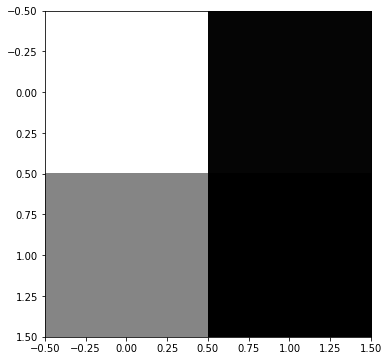

In [90]:
imgplot(features[1])

In [91]:
train_set = dataset.show()
train_set = train_set.loc[train_set['session'] == 'train']

In [106]:
images = train_set['image']
flag = 0
for image in images:
    img = np.array(image)
    feat_list = feature_extraction(img, 2, 2)
    #print(len(feat_list))
    tmp_features = snip_matrix(feat_list)
    #print(tmp_features.shape)
    if flag == 1:
        features = np.vstack((features, tmp_features))
    if flag == 0:
        features = tmp_features
        flag = 1        

In [254]:
tiles = img_keypoints(snips[1], stride = 2,size = 2)
s = snip_matrix(tiles)
from sklearn.decomposition import PCA
pca = PCA(whiten=True).fit_transform((s))

In [396]:
def add_features(dataset, session = 'train'):
    data = (dataset.show()).copy()
    session_set = data.loc[data['session'] == session]
    images = session_set['image']
    indices = images.index.values
    tmp_column = pd.DataFrame(columns = ['features'])
    flag = 0
    feat_mat = []
    for idx in indices:
        image = data.iloc[idx]['image']
        #img = np.array(image)
        feat_list = feature_extraction(image)
        temp = {'features': [feat_list]}
        temp_col = pd.DataFrame.from_records(temp)
        tmp_column = tmp_column.append(temp_col, ignore_index = True)
    #print(tmp_column)
    tmp_column['new_index'] = pd.Series(indices, index = tmp_column.index)
    tmp_column = tmp_column.set_index('new_index')
    data.loc[indices, 'features'] = tmp_column['features']
    #dataset.dataset
    #print(tmp_column)
    return data


In [221]:
features.shape

(28250, 8)

In [361]:
(dataset.show()).loc[(dataset.show())['session'] == 'train'].index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  16,
        17,  20,  21,  23,  24,  25,  26,  31,  32,  34,  36,  37,  38,
        39,  40,  41,  42,  43,  45,  47,  48,  49,  51,  52,  54,  55,
        56,  58,  59,  60,  62,  64,  65,  66,  69,  70,  73,  74,  75,
        77,  78,  79,  81,  82,  83,  84,  85,  87,  88,  90,  91,  94,
        95,  96,  97,  98, 101, 102, 105, 107, 109, 110, 113, 115, 116,
       117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131,
       132, 133, 134, 135, 138, 139, 141, 142, 143, 144, 146, 147, 148,
       149, 150, 151, 152, 153, 155, 156, 158, 161, 162, 163, 164, 165,
       167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 181,
       182, 183, 184, 185, 188, 190, 192, 193, 195, 196, 197, 198, 200,
       201, 203, 204, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219,
       220, 221, 223, 224, 225, 226, 228, 230, 231, 232, 233, 234, 235,
       236, 237, 239, 240, 241, 242, 243, 244, 246, 247, 248, 24

In [367]:
datas = add_features(dataset)

In [399]:
#Dataset with features along with them
#len(datas)
#dataset.show()
#dataset.show()
#datas.index.values
datas

,image,label,session,features
0,"[[[1466.6293, 1544.2773, 1624.8297, 1666.6348,...",0,train,"[[-0.9326008, -0.5347347, 0.1387199, -1.806629..."
1,"[[[1191.3734, 1258.4917, 1322.3187, 1382.8206,...",0,train,"[[1.6424524, 2.5763803, -2.5235643, -0.3919881..."
2,"[[[1511.6578, 1489.488, 1464.7115, 1475.9774, ...",0,train,"[[0.5984261, 1.0269182, -0.099042304, 0.754346..."
3,"[[[1225.2709, 1209.9865, 1187.9432, 1159.2587,...",0,train,"[[1.4546256, 2.6916971, -0.4077269, 1.5308206,..."
4,"[[[132.93398, 428.82263, 684.3668, 833.4219, 9...",0,train,"[[0.65525115, 3.4460416, 2.7760472, 0.26814774..."
5,"[[[1430.0679, 1449.0419, 1458.5895, 1465.036, ...",0,train,"[[0.61385036, -0.5380759, -0.1301087, 2.279543..."
6,"[[[1412.0519, 1406.2793, 1400.2579, 1380.2952,...",0,train,"[[-0.15571211, 0.03950032, 0.31570405, 0.62739..."
7,"[[[1611.9309, 1601.594, 1594.9064, 1577.0963, ...",0,train,"[[-1.120722, -0.42695168, -0.48402727, 0.20304..."
8,"[[[498.01596, 907.0142, 1057.3591, 1186.876, 1...",0,test,NaN
9,"[[[1510.5798, 1511.0724, 1499.9894, 1476.2017,...",0,train,"[[2.5554008, 2.6156485, -0.28665325, 1.3297471..."


In [369]:
#(dataset_new.loc[(dataset_new['session'] == 'train')])
#dataset_new
datas.loc[datas['session'] == 'train']

,image,label,session,features
0,"[[[1466.6293, 1544.2773, 1624.8297, 1666.6348,...",0,train,"[[-0.9326008, -0.5347347, 0.1387199, -1.806629..."
1,"[[[1191.3734, 1258.4917, 1322.3187, 1382.8206,...",0,train,"[[1.6424524, 2.5763803, -2.5235643, -0.3919881..."
2,"[[[1511.6578, 1489.488, 1464.7115, 1475.9774, ...",0,train,"[[0.5984261, 1.0269182, -0.099042304, 0.754346..."
3,"[[[1225.2709, 1209.9865, 1187.9432, 1159.2587,...",0,train,"[[1.4546256, 2.6916971, -0.4077269, 1.5308206,..."
4,"[[[132.93398, 428.82263, 684.3668, 833.4219, 9...",0,train,"[[0.65525115, 3.4460416, 2.7760472, 0.26814774..."
5,"[[[1430.0679, 1449.0419, 1458.5895, 1465.036, ...",0,train,"[[0.61385036, -0.5380759, -0.1301087, 2.279543..."
6,"[[[1412.0519, 1406.2793, 1400.2579, 1380.2952,...",0,train,"[[-0.15571211, 0.03950032, 0.31570405, 0.62739..."
7,"[[[1611.9309, 1601.594, 1594.9064, 1577.0963, ...",0,train,"[[-1.120722, -0.42695168, -0.48402727, 0.20304..."
9,"[[[1510.5798, 1511.0724, 1499.9894, 1476.2017,...",0,train,"[[2.5554008, 2.6156485, -0.28665325, 1.3297471..."
10,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0,train,"[[2.5558922, 3.997216, 0.753845, 0.3153945, -0..."


In [439]:
#Super-features ..... by using k_means clustering
#n_clusters = no of classes * 10s
def quantizer_KMeans(dataset_with_features, session = 'train', n = 20):
    ###############################################################
    ###This initial part deals with the data acquisition#$$$$$$$$$$
    dataset = dataset_with_features
    indices = dataset.loc[dataset['session'] == session].index.values
    tmp0 = (((dataset.loc[dataset['session'] == session]))['features'])
    tmp = tmp0[0]
    features_pool = np.zeros((1,tmp.shape[1]))
    for idx in (indices):
        tmp1 = (datas[datas['session'] == session])['features']
        tmp2 = tmp1[idx]
        features_pool = np.vstack((features_pool,tmp2))
    features_pool = np.delete(features_pool,0,0)
    ##############################################################
    ##############################################################
    #n = 10*2  
    #No of clusters(acc to heuristics) ---> no of classes*10
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = n).fit(features_pool)
    return kmeans

In [428]:
kmeans_bag = quantizer_KMeans(datas, 'train', 40)

In [429]:
def visual_BOW(dataset_with_features, quantizer, session, n = 20):
    ############data acquisition######################
    data = dataset_with_features
    session_set = data.loc[data['session'] == session]
    images = session_set['image']
    indices = session_set.index.values
    tmp_column = pd.DataFrame(columns = ['visual_BOW'])
    for idx in indices:
        histo = np.zeros(n)
        features = np.array(data.iloc[idx]['features'])
        n_keypoints = np.size(features)
        vals = quantizer.predict(features)
        histo[vals] += (1/n_keypoints)
        temp = {'visual_BOW': [histo]}
        temp_col = pd.DataFrame.from_records(temp)
        tmp_column = tmp_column.append(temp_col, ignore_index = True)
    #print(tmp_column)
    tmp_column['new_index'] = pd.Series(indices, index = tmp_column.index)
    tmp_column = tmp_column.set_index('new_index')
    data.loc[indices, 'visual_BOW'] = tmp_column['visual_BOW']

In [430]:
####Develop histogram of bag of words using kmeans knowledge#####
visual_BOW(datas, kmeans_bag, 'train', 40)

In [431]:
datas

,image,label,session,features,visual_BOW
0,"[[[1466.6293, 1544.2773, 1624.8297, 1666.6348,...",0,train,"[[-0.9326008, -0.5347347, 0.1387199, -1.806629...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0..."
1,"[[[1191.3734, 1258.4917, 1322.3187, 1382.8206,...",0,train,"[[1.6424524, 2.5763803, -2.5235643, -0.3919881...","[0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001, ..."
2,"[[[1511.6578, 1489.488, 1464.7115, 1475.9774, ...",0,train,"[[0.5984261, 1.0269182, -0.099042304, 0.754346...","[0.001, 0.001, 0.001, 0.0, 0.001, 0.0, 0.001, ..."
3,"[[[1225.2709, 1209.9865, 1187.9432, 1159.2587,...",0,train,"[[1.4546256, 2.6916971, -0.4077269, 1.5308206,...","[0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001..."
4,"[[[132.93398, 428.82263, 684.3668, 833.4219, 9...",0,train,"[[0.65525115, 3.4460416, 2.7760472, 0.26814774...","[0.0, 0.001, 0.001, 0.0, 0.001, 0.001, 0.001, ..."
5,"[[[1430.0679, 1449.0419, 1458.5895, 1465.036, ...",0,train,"[[0.61385036, -0.5380759, -0.1301087, 2.279543...","[0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001..."
6,"[[[1412.0519, 1406.2793, 1400.2579, 1380.2952,...",0,train,"[[-0.15571211, 0.03950032, 0.31570405, 0.62739...","[0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.00..."
7,"[[[1611.9309, 1601.594, 1594.9064, 1577.0963, ...",0,train,"[[-1.120722, -0.42695168, -0.48402727, 0.20304...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0..."
8,"[[[498.01596, 907.0142, 1057.3591, 1186.876, 1...",0,test,NaN,NaN
9,"[[[1510.5798, 1511.0724, 1499.9894, 1476.2017,...",0,train,"[[2.5554008, 2.6156485, -0.28665325, 1.3297471...","[0.001, 0.001, 0.0, 0.001, 0.001, 0.001, 0.001..."


In [432]:
print(datas.iloc[0]['visual_BOW'])
print(datas.iloc[16]['visual_BOW'])

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.
 0.001 0.001 0.001 0.001 0.001 0.001 0.    0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]
[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.
 0.001 0.    0.    0.    0.001 0.001 0.    0.001 0.    0.001 0.001 0.001
 0.001 0.001 0.    0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.   ]


In [463]:
#helper function taken from matplotlib website
#Refer to the following page : 
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
################################################################################################################
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [485]:
#Training SVM using the bag of words features
def train_classifier(dataset, feature_column, classifier):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    ###########Data Acquisition##########################
    data = dataset.loc[dataset['session'] == 'train']
    indices = data.index.values
    tmp0 = data[feature_column]
    tmp = tmp0[0]
    X = np.zeros((1,len(tmp)))
    for idx in (indices):
        tmp1 = (dataset[dataset['session'] == 'train'])[feature_column]
        tmp2 = np.array(tmp1[idx])
        X = np.vstack((X,tmp2))
    X = np.delete(X,0,0)
    #print(X.shape)
    #Why it is so hard to put arrays in there
    #X = data[feature_column]
    Y = data['label'].to_numpy()
    Y = Y.astype('int')
    #print(Y.shape)
    #######################################################
    #sys.exit()
    classifier.fit(X,Y)
    y_pred = classifier.predict(X)
    tn, fp, fn, tp = (confusion_matrix(Y,y_pred)).ravel()
    
    confusion_mat = np.array([[tp, fp],
                              [fn, tn]])
    fig, ax = plt.subplots()

    im, cbar = heatmap(confusion_mat, ['Predicted True','Predicted False'], ['Actual True','Actual False'], ax=ax,
                       cmap="Blues", cbarlabel=" [No. of samples]")
    texts = annotate_heatmap(im, valfmt="{x:.2f}")
    fig.tight_layout()
    plt.show()    
    print("Sensitivity : ", (tp/(fn+tp)))
    print("Specificity : ", (fp/(fp+tn)))
    return classifier

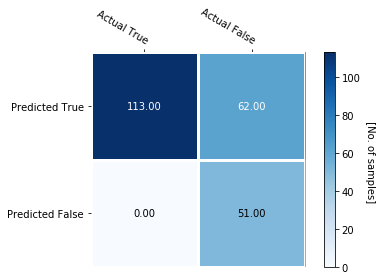

Sensitivity :  1.0
Specificity :  0.5486725663716814


In [486]:
#Defining a SVM classifier with Radial basis function kernel
from sklearn.svm import SVC
svm_classifier = SVC(gamma = 'auto')
trained_svm = train_classifier(datas, 'visual_BOW', svm_classifier)

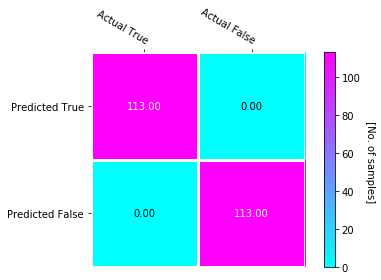

Sensitivity :  1.0
Specificity :  0.0


In [483]:
#Now classifying the data without feature extraction.
#Using the raw patch image as feature
from sklearn.metrics import confusion_matrix
X,Y = dataset.feature_matrix_raw('train')
raw_svm = SVC(gamma = 'auto')
raw_trained_svm = raw_svm.fit(X,Y)

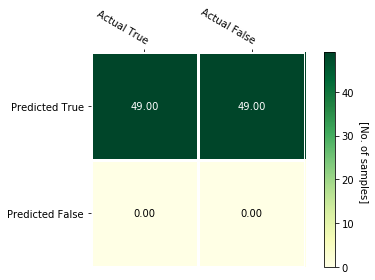

Sensitivity :  1.0
Specificity :  1.0


In [491]:
X_train,Y = dataset.feature_matrix_raw('test')
y_pred = raw_trained_svm.predict(X_train)
tn, fp, fn, tp = (confusion_matrix(Y,y_pred)).ravel()

confusion_mat = np.array([[tp, fp],
                          [fn, tn]])
fig, ax = plt.subplots()

im, cbar = heatmap(confusion_mat, ['Predicted True','Predicted False'], ['Actual True','Actual False'], ax=ax,
                   cmap="YlGn", cbarlabel=" [No. of samples]")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()    
print("Sensitivity : ", (tp/(fn+tp)))
print("Specificity : ", (fp/(fp+tn)))

In [392]:
indices = datas.loc[datas['session'] == 'train'].index.values
tmp0 = (((datas.loc[datas['session'] == 'train']))['features'])
tmp = tmp0[0]
features_pool = np.zeros((1,tmp.shape[1]))
for idx in (indices):
    tmp1 = (datas[datas['session'] == 'train'])['features']
    tmp2 = tmp1[idx]
    features_pool = np.vstack((features_pool,tmp2))
features_pool = np.delete(features_pool,0,0)

In [397]:
features_pool[0].shape

(8,)

In [441]:
datas['label'].to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [62]:
import pandas as pd
data = pd.read_pickle('RST_outputs_all/rst_output_all_subjects_2_2_0.1')

In [63]:
data.loc[data['patient_name'] == '4']

,RST_peak,image_patch,label,patient_name
212,"[150, 100, 75]","[[[1993.5889, 2027.2733, 2019.5259, 2015.476, ...",NaN,4
213,"[99, 90, 141]","[[[1571.5991, 1562.0074, 1572.0018, 1632.0538,...",NaN,4
214,"[60, 141, 51]","[[[1885.6003, 1853.675, 1800.5067, 1746.5947, ...",NaN,4
215,"[53, 49, 81]","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",NaN,4


In [65]:
from pfca.exp.results import draw_roi

In [66]:
from pfca.exp.dataset import *

In [67]:
datarep = dataset_management()
datarep.dataset = data

In [68]:
len(data)

605

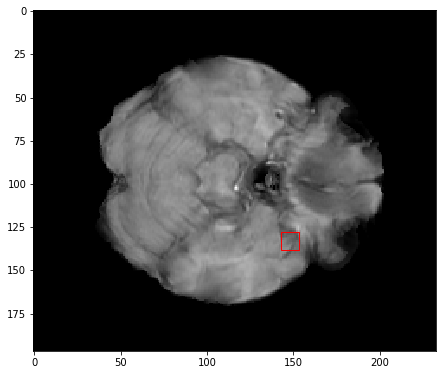

In [70]:
datarep.disp_detection('4', 500)

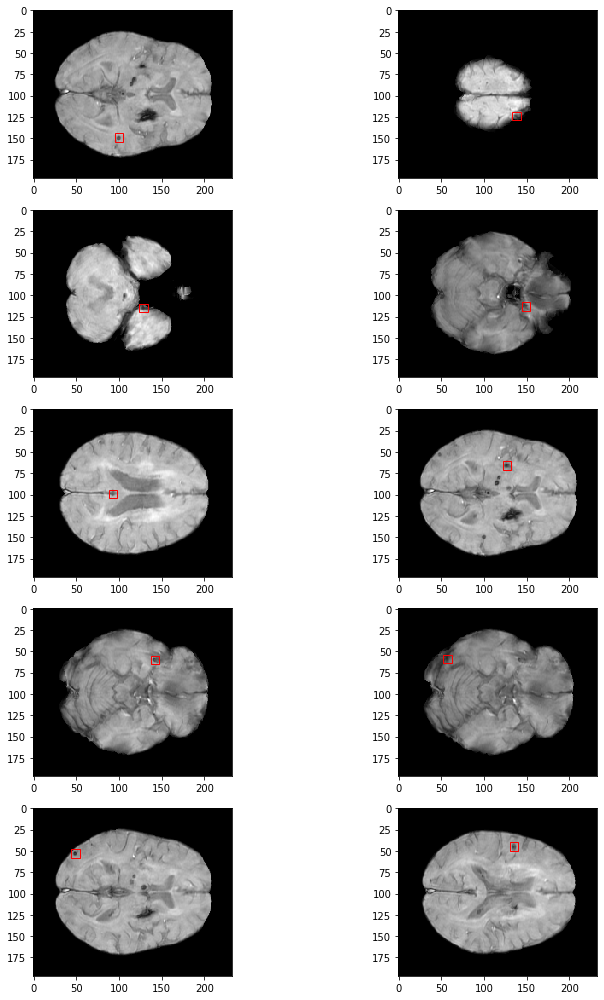

In [22]:
datarep.disp_roi('4')

In [59]:
def store_results(dataset, r, folder_name):
    d = dataset     #Writing so long names is not cool enough
    ###First make a folder for storing all the images
    import os
    from skimage.draw import rectangle_perimeter
    import matplotlib.patches as mpathches   
    from pfca.core.preprocessing import nifti_ANTS, mni_template_registration
    cur_path = os.getcwd()
    snips_dir = str(cur_path)+"/visuals/RST_snips/"+ folder_name + "/"
    try:
        os.makedirs(snips_dir)
    except FileExistsError:
        print("Directory Exists!")
    ############
    #Moving to the important stuff...Get Data...
    #peaks = d['RST_peak'].tolist()
    ###########
    from matplotlib import pyplot as plt
    for i in range(len(d)):    
        plt.figure(figsize = (12,14))
        p = (d.iloc[i]['RST_peak']).tolist()
        patient = d.iloc[i]['patient_name']
        im_nifti = nifti_ANTS(nifti_dir, patient, category='eswan', unskulled=True)
        image = mni_template_registration(cur_path, im_nifti, patient)        
        temp = image[:,:,p[2]]
        plt.imshow(temp, cmap = plt.get_cmap('gray'))
        plt.title("Patient : " + patient + "; " + "Coordinate : " + str(p))
        ax = plt.gca()
        rect = mpathches.Rectangle((p[1]-r, p[0]-r), 2*r, 2*r,
                                  fill= False, edgecolor = 'red', linewidth = 1)
        ax.add_patch(rect)
        #ax.set_axis_off()
        plt.savefig(snips_dir + patient + "_" + str(i) + ".png")
        plt.close()
    #plt.tight_layout()     

In [71]:
store_results(data, 5, 'rst_output_all_subjects_2_2_0.1')

In [16]:
cerebellum_atlas = ants.image_read(nifti_dir + '/MNI-maxprob-thr50-1mm.nii')

In [12]:
cerebellum_atlas

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [13]:
cerebellum_atlas = cerebellum_atlas.numpy()

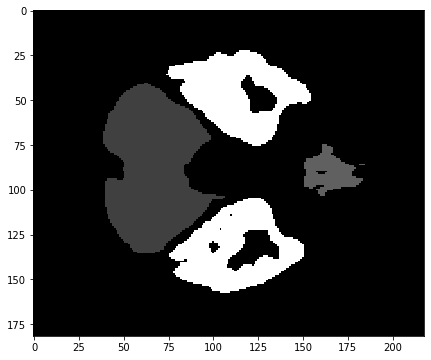

In [14]:
imgplot(cerebellum_atlas, slice_no=[45])

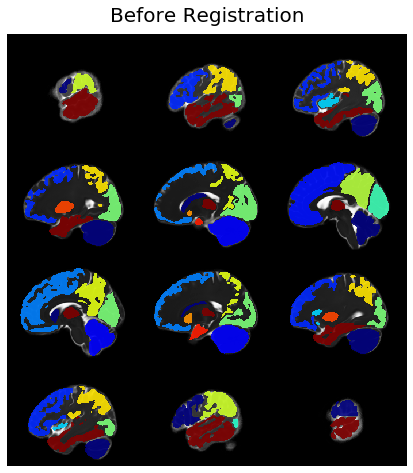

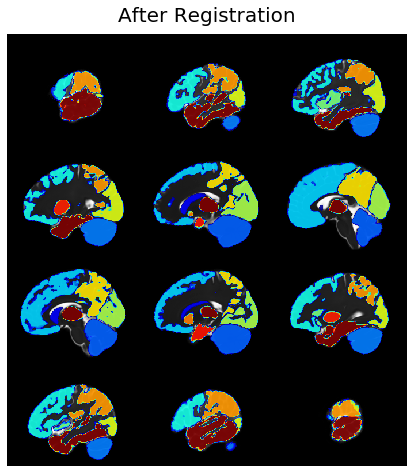

In [17]:
#Registering Harvard-Oxford Atlas with MNI-152 template using non-linear registration
cerebellum_mni = mni_template_registration(cur_path,cerebellum_atlas,'MNI-maxprob-thr50-1mm')

In [18]:
cerebellum_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

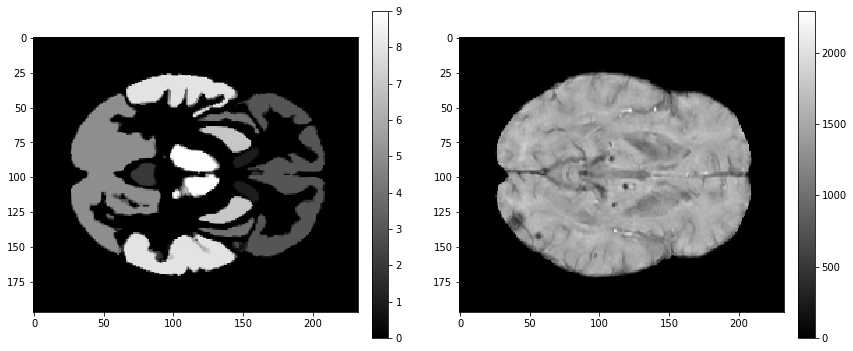

In [21]:
imgplot(cerebellum_mni,im_patient, slice_no=[67,67])

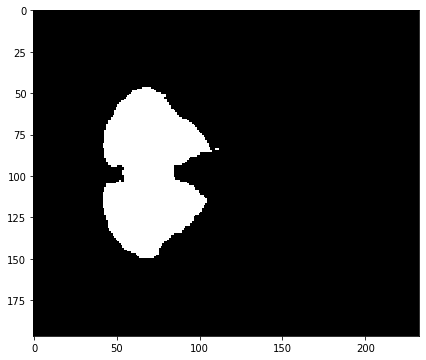

In [25]:
cerebellum_mni = cerebellum_mni.numpy()
cerebellum_mni = (cerebellum_mni == 2)
imgplot(cerebellum_mni, slice_no=[45])

In [52]:
k = [1,2,2]
str(k)

'[1, 2, 2]'